## Import Libraries

In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

np.random.seed(42)

## Load Data

In [27]:
train_data = pd.read_csv("CMAPSSData/train_FD001.txt", sep="\s+", header=None)
test_data = pd.read_csv("CMAPSSData/test_FD001.txt", sep="\s+", header=None)
true_rul = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep='\s+', header=None)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/vm/qmpgz1kx11d1b81b4_m3pxx80000gn/T/ipykernel_20038/113227255.py:1: SyntaxWarning: invalid escape sequence '\s'
  train_data = pd.read_csv("CMAPSSData/train_FD001.txt", sep="\s+", header=None)
/var/folders/vm/qmpgz1kx11d1b81b4_m3pxx80000gn/T/ipykernel_20038/113227255.py:2: SyntaxWarning: invalid escape sequence '\s'
  test_data = pd.read_csv("CMAPSSData/test_FD001.txt", sep="\s+", header=None)
/var/folders/vm/qmpgz1kx11d1b81b4_m3pxx80000gn/T/ipykernel_20038/113227255.py:3: SyntaxWarning: invalid escape sequence '\s'
  true_rul = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep='\s+', header=None)


<Figure size 1600x1200 with 0 Axes>

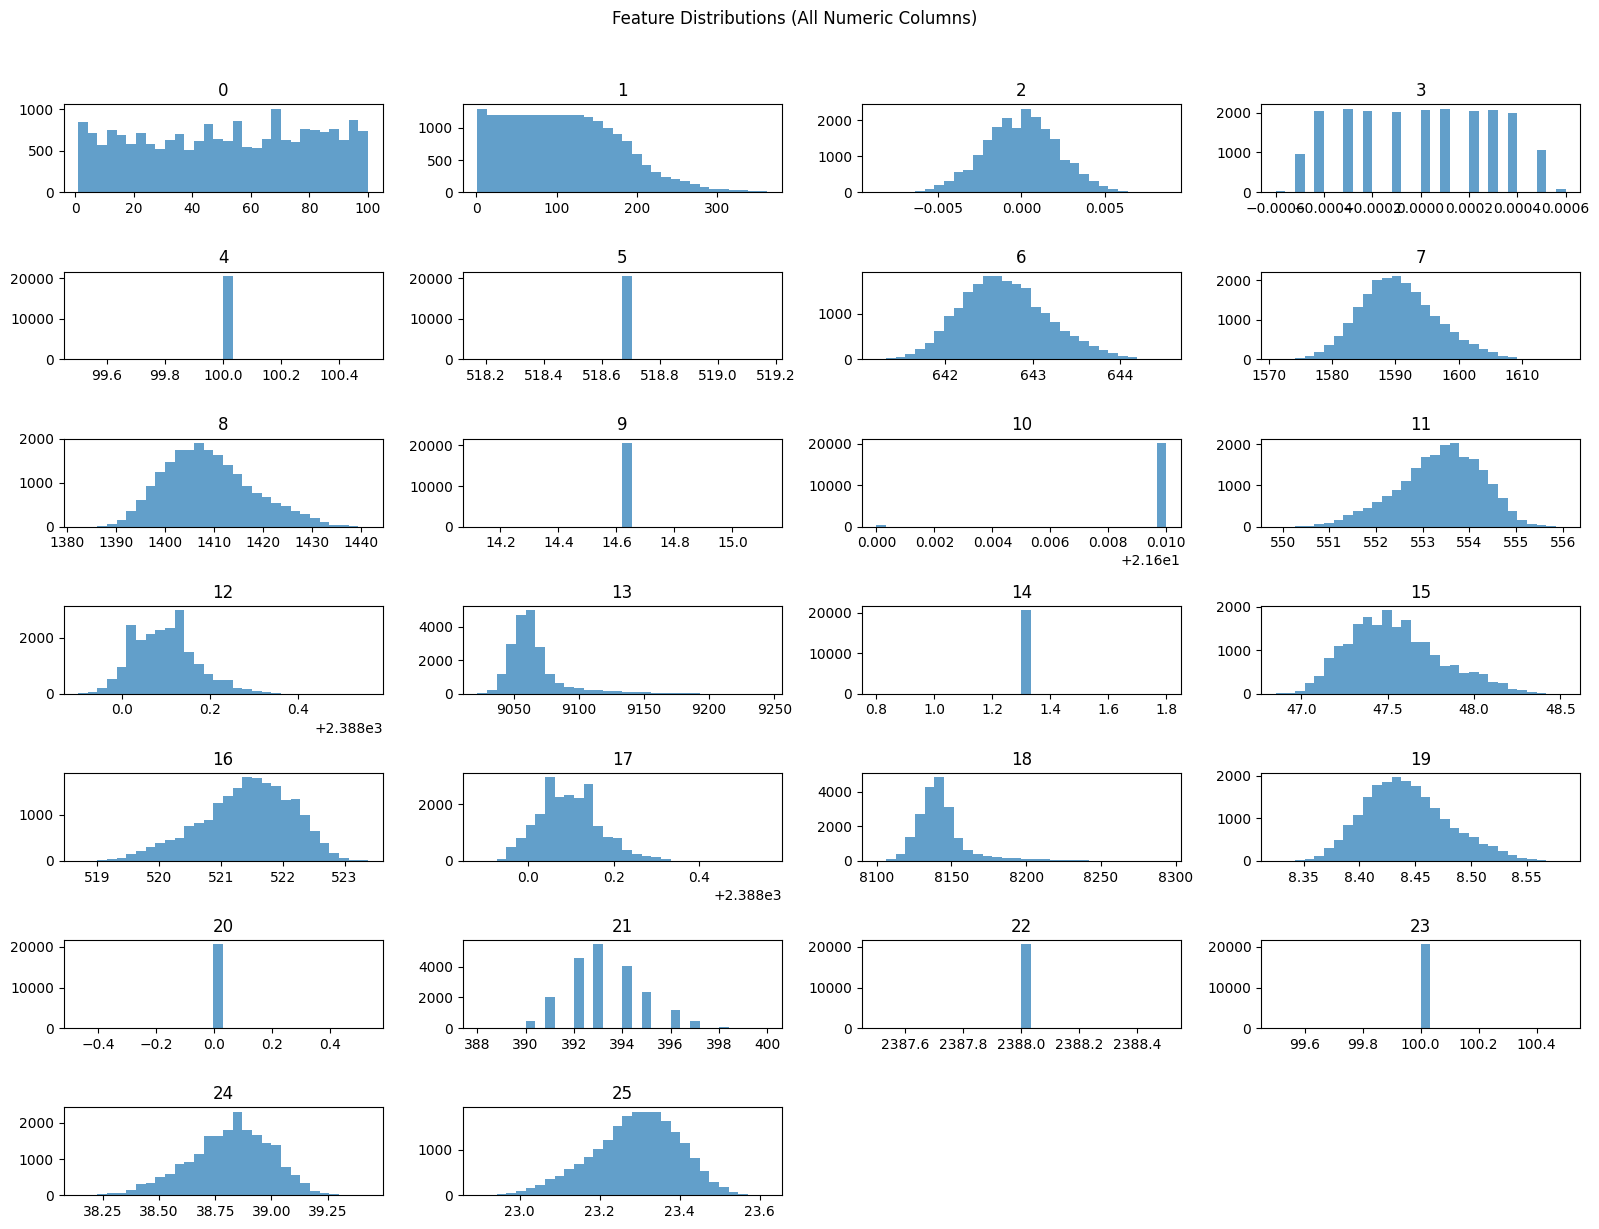

In [28]:
# Histogram
plt.figure(figsize=(16, 12))

# Plot histograms for all numeric columns
train_data.select_dtypes(include=['number']).hist(bins=30,
                                                alpha=0.7,
                                                layout=(-1, 4),
                                                figsize=(16, 12),
                                                grid=False)

plt.suptitle('Feature Distributions (All Numeric Columns)', y=1.02)
plt.tight_layout()
plt.show()

In [29]:
# Checking Null values
train_data.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
dtype: int64

In [30]:
from sklearn.impute import SimpleImputer
import pickle

imputer = SimpleImputer(strategy='mean')

# Fit on training data (numeric columns only)
numeric_cols = train_data.select_dtypes(include=['number']).columns
imputer.fit(train_data[numeric_cols])

SimpleImputer()

## After SimpleImputer

In [31]:
train_data.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
dtype: int64

## Basic Data Inspection

In [32]:
# 1. DATA INSPECTION
print("\n=== Training Data Info ===")
print(train_data.info())
print("\n=== Test Data Info ===")
print(test_data.info())

print("\n=== Training Data Describe ===")
print(train_data.describe())
print("\n=== Test Data Describe ===")
print(test_data.describe())


=== Training Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  int64  
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21     

## Target Distribution (RUL)

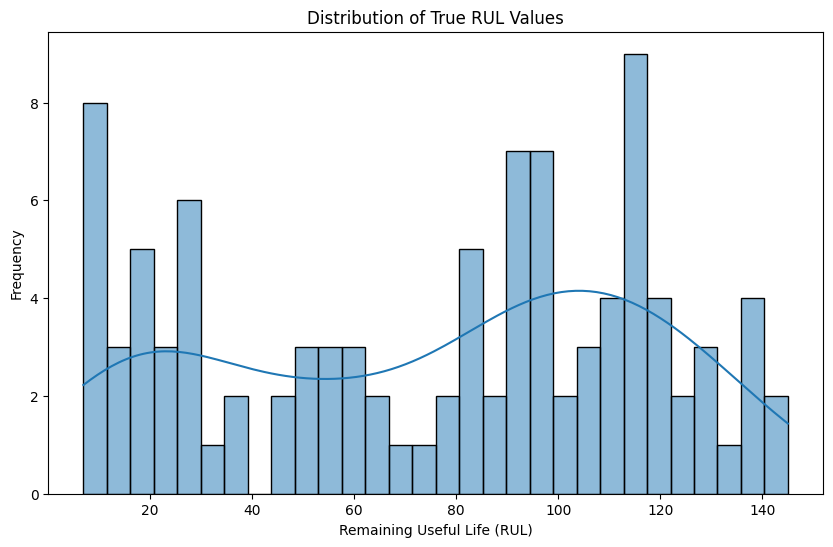

'\nWhat this does:\n- Visualizes the distribution of Remaining Useful Life values\n- Shows how RUL values are distributed across all engines\n- KDE line shows the probability density\n- Helps identify if RUL values are skewed or have outliers\n'

In [33]:
# 2. TARGET DISTRIBUTION ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(true_rul[0], bins=30, kde=True)
plt.title('Distribution of True RUL Values')
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.show()

"""
What this does:
- Visualizes the distribution of Remaining Useful Life values
- Shows how RUL values are distributed across all engines
- KDE line shows the probability density
- Helps identify if RUL values are skewed or have outliers
"""

## Feature Correlation Analysis

In [34]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044


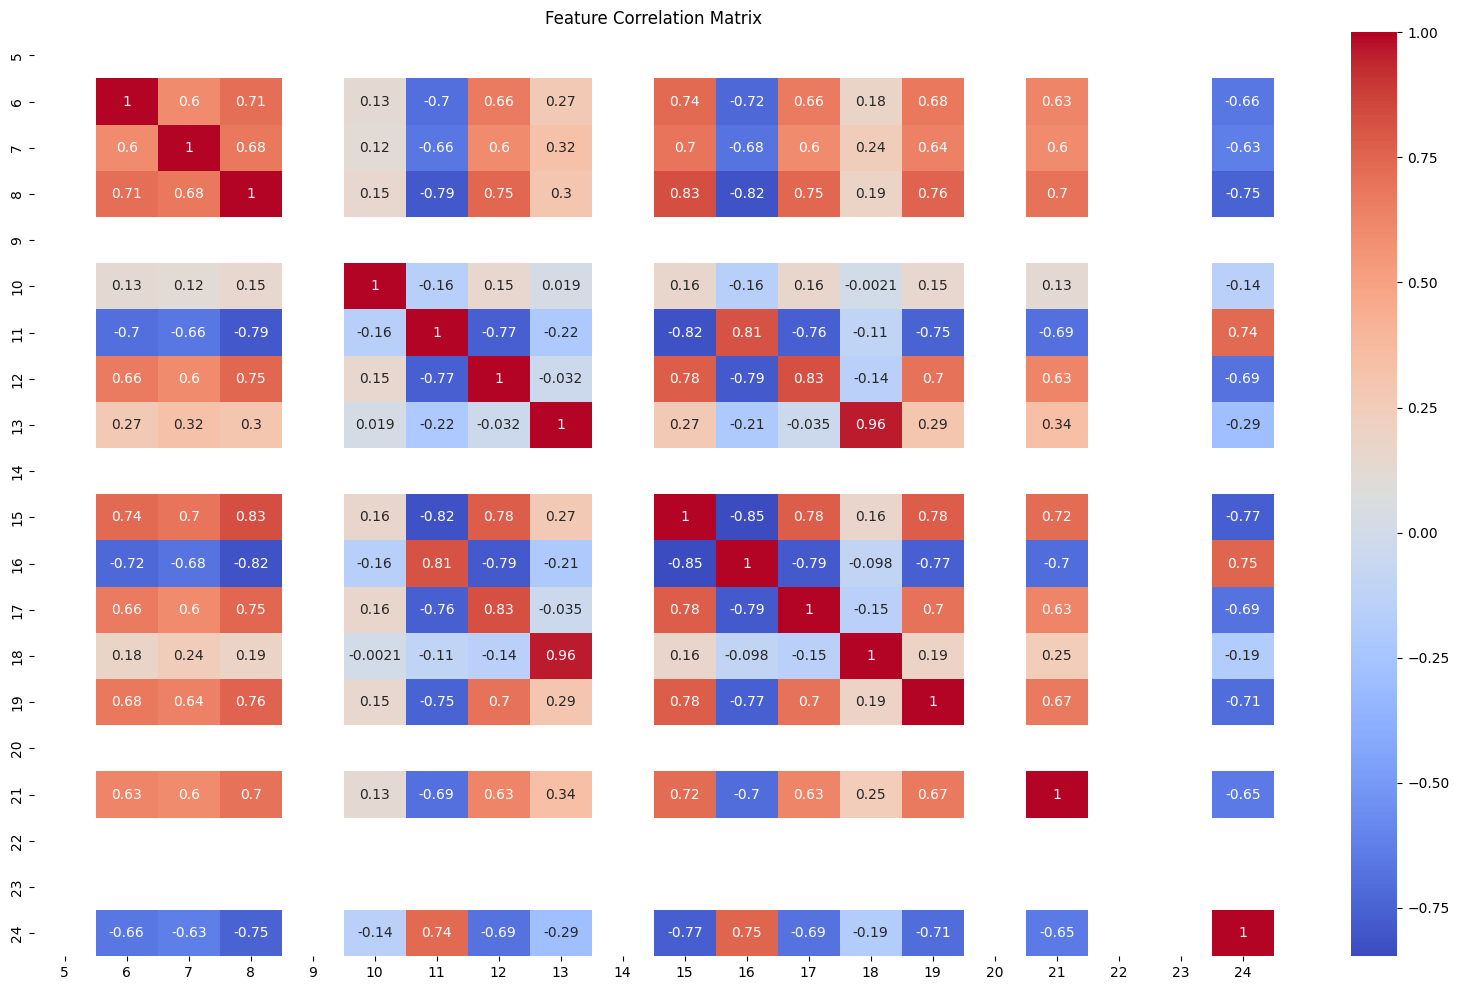

'\nWhat this does:\n- Shows relationships between different sensor readings\n- High positive (red) or negative (blue) correlations may indicate important features\n- Helps identify redundant features (highly correlated pairs)\n- Annotated values show exact correlation coefficients\n'

In [35]:
# 3. FEATURE CORRELATION ANALYSIS

# Select some key features (adjust columns
features_to_plot = [i for i in range(5, 25)]  # Example sensor columns
plt.figure(figsize=(20, 12))
sns.heatmap(train_data[features_to_plot].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

"""
What this does:
- Shows relationships between different sensor readings
- High positive (red) or negative (blue) correlations may indicate important features
- Helps identify redundant features (highly correlated pairs)
- Annotated values show exact correlation coefficients
"""

## Helper Functions

In [36]:
# Generates Remaining Useful Life (RUL) targets for training data.
def process_targets(data_length, early_rul):

    # Create decreasing sequence from (data_length-1) to 0
    targets = np.arange(data_length)[::-1]

    # Clip values to not exceed early_rul (early stopping threshold)
    targets = np.clip(targets, 0, early_rul)

    return targets

In [37]:
# Processes input data into sliding windows with corresponding targets.
def process_input_data_with_targets(data, targets, window_length, shift):

    windowed_data = []
    windowed_targets = []

    # Slide window across the time series
    for i in range(0, len(data) - window_length + 1, shift):

        # Extract window of features
        windowed_data.append(data[i:i + window_length])

        # Get target (RUL) at the last time step of the window
        windowed_targets.append(targets[i + window_length - 1])

    return np.array(windowed_data), np.array(windowed_targets)

In [38]:
def process_test_data(data, window_length, shift, num_test_windows):

    # Calculate how many windows we can actually make
    if len(data) < num_test_windows * shift + window_length - 1:
        # If data is shorter than desired, use maximum possible windows
        num_windows = (len(data) - window_length + 1) // shift
    else:
        # Otherwise use the requested number
        num_windows = num_test_windows

    windowed_data = []

    # Create windows starting from the end of the time series
    start_idx = len(data) - (num_windows * shift + window_length - 1)
    for i in range(start_idx, len(data) - window_length + 1, shift):
        windowed_data.append(data[i:i + window_length])

    return np.array(windowed_data), num_windows

## Data Preprocessing Parameters

In [39]:
# DATA PREPROCESSING PARAMETERS
window_length = 1
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine are taken. If set to a different number, that many windows from last are taken.
# Final output is the average of output of all windows.

num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0, 1, 2, 3, 4, 5, 9, 10, 14, 20, 22, 23]

num_machines = min(len(train_data[0].unique()), len(test_data[0].unique()))

## Process Data for Each Machine

In [40]:
# PROCESS DATA FOR EACH MACHINE

for i in range(1, num_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_test_data = test_data[test_data[0] == i].drop(columns=columns_to_be_dropped).values

    # Verify if data of given window length can be extracted from both training and test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                            "Try decreasing window length.")
    elif (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                            "Try decreasing window length.")

    temp_train_targets = process_targets(data_length=temp_train_data.shape[0], early_rul=early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(
        temp_train_data, temp_train_targets,
        window_length=window_length, shift=shift
    )

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(
        temp_test_data, window_length=window_length, shift=shift,
        num_test_windows=num_test_windows
    )

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

## Concatenate and Shuffle Data

In [41]:
# Concatenate all machine data into single arrays
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
processed_test_data = np.concatenate(processed_test_data)

# Extract true RUL values from DataFrame to numpy array
true_rul = true_rul[0].values  # Converts single-column DataFrame to 1D array

# Shuffle training data to prevent order-related biases
index = np.random.permutation(len(processed_train_targets))
# Applies same shuffle to both features and targets to maintain correspondence
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

# Shape verification
print("Processed training data shape: ", processed_train_data.shape)  # Expected: (n_samples, window_length, n_features)
print("Processed training RULs shape: ", processed_train_targets.shape)  # Expected: (n_samples,)
print("Processed test data shape: ", processed_test_data.shape)  # Expected: (n_test_samples, window_length, n_features)
print("True RUL shape: ", true_rul.shape)  # Expected: (n_test_engines,)

# Reshape for modeling
# Flatten the window dimension for tree-based models (RF/XGBoost)
# From 3D (samples, window_length, features) to 2D (samples, window_length*features)
processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[2])
processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[2])

print("Reshaped train data shape: ", processed_train_data.shape)  # Now 2D array
print("Reshaped test data shape: ", processed_test_data.shape)  # Now 2D array

Processed training data shape:  (20631, 1, 14)
Processed training RULs shape:  (20631,)
Processed test data shape:  (500, 1, 14)
True RUL shape:  (100,)
Reshaped train data shape:  (20631, 14)
Reshaped test data shape:  (500, 14)


## Random Forest Model

In [42]:
# RANDOM FOREST MODEL
rf_model = RandomForestRegressor(n_estimators= 300, max_features = "sqrt",
                                 n_jobs = -1, random_state = 38)
rf_model.fit(processed_train_data, processed_train_targets)
rul_pred = rf_model.predict(processed_test_data)

# First split predictions according to number of windows of each engine
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

## XGBoost Model

In [43]:
# XGBOOST MODEL
xgb_model = XGBRegressor(n_estimators=300, max_features="sqrt",
                         n_jobs=-1, random_state=38)
xgb_model.fit(processed_train_data, processed_train_targets)
rul_pred = xgb_model.predict(processed_test_data)

# First split predictions according to number of windows of each engine
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights=np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

/Users/rajarshiroy/Projects/industry_4.0/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Model Evaluation Metrics

In [44]:
# MODEL EVALUATION METRICS

# For Random Forest model
rf_preds_for_each_engine = np.split(rf_model.predict(processed_test_data), np.cumsum(num_test_windows_list)[:-1])
rf_mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights=np.repeat(1/num_windows, num_windows))
                               for ruls_for_each_engine, num_windows in zip(rf_preds_for_each_engine, num_test_windows_list)]

rf_rmse = np.sqrt(mean_squared_error(true_rul, rf_mean_pred_for_each_engine))
rf_mae = mean_absolute_error(true_rul, rf_mean_pred_for_each_engine)
rf_r2 = r2_score(true_rul, rf_mean_pred_for_each_engine)

print("Random Forest Metrics:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R2 Score: {rf_r2:.4f}")

# For XGBoost model
xgb_preds_for_each_engine = np.split(xgb_model.predict(processed_test_data), np.cumsum(num_test_windows_list)[:-1])
xgb_mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights=np.repeat(1/num_windows, num_windows))
                                for ruls_for_each_engine, num_windows in zip(xgb_preds_for_each_engine, num_test_windows_list)]

xgb_rmse = np.sqrt(mean_squared_error(true_rul, xgb_mean_pred_for_each_engine))
xgb_mae = mean_absolute_error(true_rul, xgb_mean_pred_for_each_engine)
xgb_r2 = r2_score(true_rul, xgb_mean_pred_for_each_engine)

print("\nXGBoost Metrics:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"R2 Score: {xgb_r2:.4f}")

Random Forest Metrics:
RMSE: 19.1698
MAE: 14.4868
R2 Score: 0.7872

XGBoost Metrics:
RMSE: 19.2286
MAE: 13.8577
R2 Score: 0.7859
